# Preprocessing Text

In [41]:
import numpy as np
from collections import Counter, OrderedDict

dataset="wpp"
input_file = f"Baselines/textual_folds/{dataset}/{dataset}Pre.txt"

text_tokens = []
vocab = []
with open(input_file, "r") as file:
    for text in file:
        tokens = text.strip().split()
        text_tokens.append(tokens)
        vocab += tokens
        
vocab = np.sort(np.asarray(list(set(vocab))))

vocab_dict = {vocab[idx]: idx + 1 for idx in range(len(vocab))}

output_file = f"Baselines/textual_folds/{dataset}/vocab.{dataset}.txt"
with open(output_file, "w") as output:
    for token in vocab:
        output.write(f"{token}\n") 
    
    output.close()
    
nnz_list = []
for idx in range(len(text_tokens)):
    text_dict =  OrderedDict(sorted(Counter(text_tokens[idx]).items()))
    doc_id = idx + 1
    for key, value in text_dict.items():
        nnz_list.append([doc_id, vocab_dict[key] ,value])

output_file = f"Baselines/textual_folds/{dataset}/docword.{dataset}.txt"
with open(output_file, "w") as output:
    output.write(f"{len(text_tokens)}\n")
    output.write(f"{len(vocab)}\n")
    output.write(f"{len(nnz_list)}\n")
    for token in nnz_list:
        output.write(f"{token[0]} {token[1]} {token[2]}\n")
    output.close()


# BigARTM

http://docs.bigartm.org/en/latest/tutorials/python_tutorial.html

In [42]:
# !pip install bigartm

In [43]:
# import artm

# batch_vectorizer = artm.BatchVectorizer(
#     data_path='topic_modeling_datasets/wpp', 
#     data_format='bow_uci',
#     collection_name='wpp', 
#     target_folder='topic_modeling_datasets/wpp_batches'
# )

In [44]:
# lda = artm.LDA(num_topics=15, alpha=0.01, beta=0.001, cache_theta=True,
#                num_document_passes=5, dictionary=batch_vectorizer.dictionary)

# lda.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

# print(f"Phi: {lda.sparsity_phi_last_value}")
# print(f"Theta: {lda.sparsity_theta_last_value}")
# print(f"Perplexity: {lda.perplexity_value}")

# top_tokens = lda.get_top_tokens(num_tokens=10)
# for i, token_list in enumerate(top_tokens):
#      print(f"Topic #{i}: {token_list}")


## Training ARTM

In [45]:
import glob
import os
import matplotlib.pyplot as plt

import artm


# dataset = "acm"
dataset_path = f"Baselines/textual_folds/{dataset}"
batch_vectorizer = artm.BatchVectorizer(data_path=f"{dataset_path}", data_format='bow_uci',
                                        collection_name=f"{dataset}", target_folder=f"{dataset}")

In [46]:
dictionary = batch_vectorizer.dictionary
topic_info = {
    "number_topics": 15,
    "words": 10
}

topic_names = ['topic_{}'.format(i) for i in range(topic_info["number_topics"])]
topic_names[:5]

['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4']

In [47]:
model_artm = artm.ARTM(
    topic_names=topic_names, 
    cache_theta=True,
    scores=[
        artm.PerplexityScore(
            name='PerplexityScore',
            dictionary=dictionary
        )
    ],
    regularizers=[
        artm.SmoothSparseThetaRegularizer(
            name='SparseTheta',
            tau=-0.15
        )
    ],
    seed=243
)

model_artm.scores.add(
    artm.SparsityPhiScore(
        name='SparsityPhiScore')
)

model_artm.scores.add(
    artm.SparsityThetaScore(
        name='SparsityThetaScore'
    )
)

model_artm.scores.add(
    artm.TopicKernelScore(
        name='TopicKernelScore',
        probability_mass_threshold=0.3
    )
)

model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='SparsePhi', 
        tau=-0.25
    )
)

model_artm.regularizers.add(
    artm.DecorrelatorPhiRegularizer(
        name='DecorrelatorPhi', 
        tau=2.5e+5
    )
)

model_artm.num_document_passes = 1000
model_artm.set_parent_model(parent_model=model_artm, parent_model_weight = 0.90)
model_artm.initialize(dictionary)

model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=topic_info["words"]))

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1000)

In [48]:
# for topic_name in model_artm.topic_names:
#     print(f"{topic_name} {' '.join(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])}")


In [49]:
import pandas as pd

def subtopics_wrt_topic(topic_number, matrix_dist):
    rank_list = matrix_dist.iloc[:, topic_number].sort_values(ascending = False)
    return rank_list[rank_list != 0].index


subt = pd.DataFrame(model_artm.get_parent_psi())
subt.columns = ['topic_{}'.format(i) for i in range(topic_info["number_topics"])]
subt.index = ['subtopic_{}'.format(i) for i in range(topic_info["number_topics"])]

subt = subt.mask(subt.rank(axis=1, method='min', ascending=False).gt(2), 0)
subt 

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
subtopic_0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
subtopic_1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
subtopic_2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
subtopic_3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
subtopic_4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
subtopic_5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
subtopic_6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
subtopic_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
subtopic_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
subtopic_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [50]:
with open(f"""Baselines/hArtmTopicResults/topic_words_{topic_info["words"]}_{dataset}Pre""", "w") as outputfile:
    for topic_id in range(0, topic_info["number_topics"]):
        for subtopic_id in subtopics_wrt_topic(topic_id, subt):
            topic_name_str = f"""{subtopic_id.split("_")[1]}"""
            if str(topic_id) == topic_name_str:
                outputfile.write(f"""{" ".join(model_artm.score_tracker['TopTokensScore'].last_tokens[f"topic_{topic_name_str}"])}\n""")
            else:
                outputfile.write(f"""\t{" ".join(model_artm.score_tracker['TopTokensScore'].last_tokens[f"topic_{topic_name_str}"])}\n""")
    
    outputfile.close()

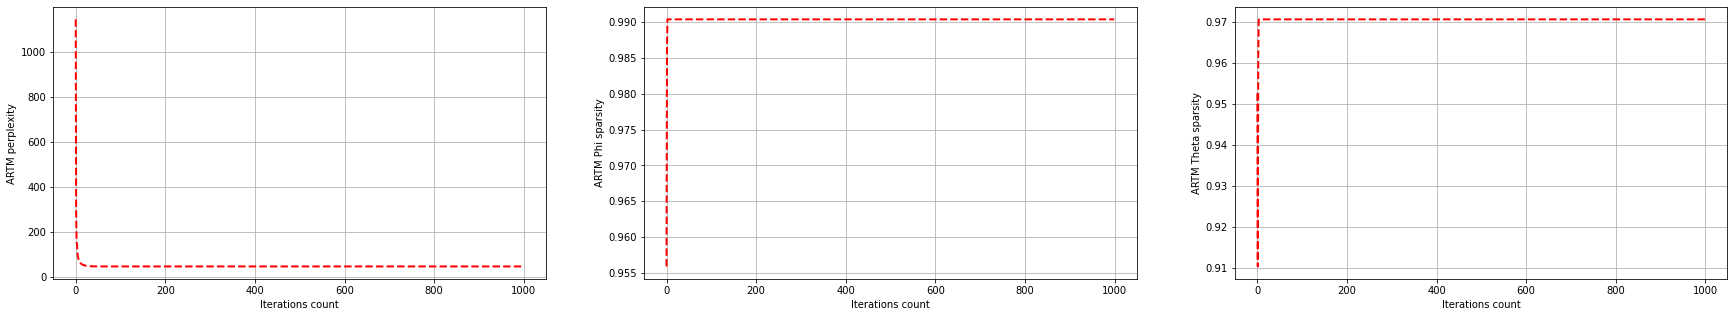

In [51]:
import matplotlib.pyplot as plt

def print_measures(model_artm, topic_info):
    with open(f"Baselines/hArtmTopicResults/last_scores_{dataset}.txt\n", "w") as output_file:
        output_file.write('Sparsity Phi ARTM:{}\n'.format(model_artm.score_tracker['SparsityPhiScore'].last_value))
        output_file.write('Sparsity Theta ARTM:{}\n'.format(model_artm.score_tracker['SparsityThetaScore'].last_value))
        output_file.write('Perplexity ARTM: {}\n'.format(model_artm.score_tracker['PerplexityScore'].last_value))
        output_file.write('Number of topics:{}\n'.format(topic_info["number_topics"]))
        output_file.write('Number of words:{}\n'.format(topic_info["words"]))
        output_file.close()
    
    ig, axs = plt.subplots(1, 3, figsize = (30, 5))
    
    for idx, score, y_label in zip(range(3), ['PerplexityScore', 'SparsityPhiScore', 'SparsityThetaScore'], ['ARTM perplexity', 'ARTM Phi sparsity', 'ARTM Theta sparsity']):
        axs[idx].plot(range(model_artm.num_phi_updates), model_artm.score_tracker[score].value, 'r--', linewidth=2)
        axs[idx].set_xlabel('Iterations count')
        axs[idx].set_ylabel(y_label)
        axs[idx].grid(True)
        
    plt.savefig(f"Baselines/hArtmTopicResults/scores_{dataset}.png")
    
print_measures(model_artm, topic_info)

**Futher Cells (I need to test yet)** 

In [52]:
# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw
# from nltk.stem import WordNetLemmatizer, PorterStemmer
# import string

# lemmatizer=WordNetLemmatizer()

# ps = PorterStemmer()
# cachedStopWords = ["fig", "figure", "et", "al", "table", "data", "analysis", "analyze", "study", "method", "result", "conclusion", "author", "find", "found", "show", "perform", "demonstrate", "evaluate", "discuss", "google", "scholar", "pubmed", "web", "science", "crossref", "supplementary", "(fig.)", "(figure", "fig.", "al.", "did", "thus,", "…", "" "", "interestingly", "and/or", "author"] + list(esw)

# def lemmatize_article(sentence):
#     sentence = word_tokenize(sentence)
#     res = ''
#     for word in sentence:
#         word = lemmatizer.lemmatize(word)
#     res += word + ' '
#     return res
    
# def remove_stop_words(sentence):
#     return ' '.join([word for word in sentence.split() if word not in cachedStopWords])
    
# def remove_short(sentence):
#     return ' '.join([word for word in sentence.split() if len(word) >= 3])
    
# def remove_digits(sentence):
#     return ' '.join([i for i in sentence.split() if not i.isdigit()])
    
# def preprocess(all_texts):
#     all_texts = list(map(lambda x: x.lower(), all_texts))
#     all_texts = list(map(lambda x: x.translate(str.maketrans('', '', string.punctuation)), all_texts))
#     all_texts = list(map(lambda x: lemmatize_article(x), all_texts))
#     all_texts = list(map(lambda x: x.strip(), all_texts))
#     all_texts = list(map(lambda x: remove_stop_words(x), all_texts))
#     all_texts = list(map(lambda x: remove_short(x), all_texts))
#     all_texts = list(map(lambda x: remove_digits(x), all_texts))
#     return all_texts
    
    
# all_texts = preprocess(all_texts)
# all_texts[111]

In [53]:
# def get_ngrams(text, n ):
#     n_grams = ngrams(word_tokenize(text), n)
#     return [' '.join(grams) for grams in n_grams]

# bigrams = []
# for article in all_texts:
#     bigrams += list(map(lambda x: x[0], list(filter(lambda x: x[1] >= 5, Counter(get_ngrams(article, 2)).most_common()))))
    
# bigrams = list(filter(lambda x: 'package' not in x and 'document' not in x, bigrams))
# bigrams = list(map(lambda x: x[0], (list(filter(lambda x: x[1] >= 5, Counter(bigrams).most_common())))))

# print(len(bigrams))
# print(bigrams[:5])

In [54]:
# from sklearn.feature_extraction.text import CountVectorizer

# n_wd_bigrams = np.empty((len(bigrams), len(all_texts)))

# for i in range(len(bigrams)):
#     for j in range(len(all_texts)):
#         n_wd_bigrams[i][j] = all_texts[j].count(bigrams[i])
        
# cv = CountVectorizer(max_features = features, stop_words='english')
# n_wd = np.array(cv.fit_transform(all_texts).todense()).T
# vocabulary = cv.get_feature_names()

# n_wd = np.concatenate((n_wd, n_wd_bigrams))
# vocabulary += bigrams

**Topic Modeling**

In [55]:
# import artm

# model_artm = artm.ARTM(topic_names = topic_names, 
#                        cache_theta=True, 
#                        scores=[
#                            artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary), 
#                            artm.SparsityPhiScore(name='SparsityPhiScore'),
#                            artm.SparsityThetaScore(name='SparsityThetaScore'),
#                            artm.TopicKernelScore(name='TopicKernelScore',probability_mass_threshold=0.3), 
#                            artm.TopTokensScore(name='TopTokensScore', num_tokens=8)
#                        ],
#                        regularizers=[
#                            artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.4),
#                            artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5)
#                        ]
#                       )
                                     
# model_artm.num_document_passes = 4
# model_artm.initialize(dictionary)
# model_artm.fit_offline(batch_vectorizer=bv, num_collection_passes=20)

**Looking the measures**

In [56]:
# import matplotlib.pyplot as plt

# def print_measures(model_artm):
#     print('Sparsity Phi ARTM:{}'.format(model_artm.score_tracker['SparsityPhiScore'].last_value))
#     print('Sparsity Theta ARTM:{}'.format(model_artm.score_tracker['SparsityThetaScore'].last_value))
#     print('Perplexity ARTM: {}'.format(model_artm.score_tracker['PerplexityScore'].last_value))
    
#     ig, axs = plt.subplots(1, 3, figsize = (30, 5))
    
#     for idx, score, y_label in zip(range(3), ['PerplexityScore', 'SparsityPhiScore', 'SparsityThetaScore'], ['ARTM perplexity', 'ARTM Phi sparsity', 'ARTM Theta sparsity']):
#         axs[idx].plot(range(model_artm.num_phi_updates), model_artm.score_tracker[score].value, 'r--', linewidth=2)
#         axs[idx].set_xlabel('Iterations count')
#         axs[idx].set_ylabel(y_label)
#         axs[idx].grid(True)

**Looking the topics**

In [57]:
# for topic_name in model_artm.topic_names: 
#     print(topic_name + ': ' +  model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

In [58]:
# def get_articles_on_theme(dataset, topic, num_topics):
#     theta = np.array(model_artm.get_theta('topic_{}'.format(topic)).iloc[0]).theta[theta <= 0.05] = 0
#     idx = np.nonzero(theta)[0]
#     articles = zip(idx, theta[idx])
#     articles = sorted(articles, key = lambda x: x[1], reverse = True)
#     articles = [x[0] for x in articles]
#     return dataset.iloc[articles].PaperText[:num_topics]
    
# get_articles_on_theme(df, 8, 5)

**Hierarchical Topic Modeling**

In [59]:
# topic_names = ['topic_{}'.format(i) for i in range(50)]

# model_artm1 = artm.ARTM(
#     topic_names=topic_names,
#     cache_theta=True, 
#     scores=[
#         artm.PerplexityScore(name='PerplexityScore',                                
#                              dictionary=dictionary), 
#         artm.SparsityPhiScore(name='SparsityPhiScore'),                                      
#         artm.SparsityThetaScore(name='SparsityThetaScore'), 
#         artm.TopicKernelScore(name='TopicKernelScore',
#                               probability_mass_threshold=0.3),
#         artm.TopTokensScore(name='TopTokensScore', 
#                             num_tokens=12)
#     ],
#     regularizers=[
#             artm.SmoothSparseThetaRegularizer(name='SparseTheta', 
#                                               tau=-0.4),
#             artm.SmoothSparsePhiRegularizer(name='SparsePhi',tau=-0.25),
#             artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+5)
#     ], 
#     seed=243
# )
                        
# model_artm1.num_document_passes = 4
# model_artm1.set_parent_model(parent_model=model_artm, parent_model_weight = 0.75)
# model_artm1.initialize(dictionary)

# model_artm1.fit_offline(batch_vectorizer=bv, num_collection_passes=12)

# subt = pd.DataFrame(model_artm1.get_parent_psi())
# subt.columns = ['topic_{}'.format(i) for i in range(10)]
# subt.index = ['subtopic_{}'.format(i) for i in range(50)]

In [60]:
# def subtopics_wrt_topic(topic_number, matrix_dist):
#     return matrix_dist.iloc[:, topic_number].sort_values(ascending = False)[:5]

# subtopics_wrt_topic(0, subt)